In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [5]:
df_train = pd.read_csv('../../additional_materials/data/train.csv', index_col=0)
print(df_train.shape)
df_train.info()

(189891, 2)
<class 'pandas.core.frame.DataFrame'>
Index: 189891 entries, 21098 to 210988
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   text       189891 non-null  object
 1   sentiment  189891 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [135]:
texts, labels = df_train.text.values, df_train.sentiment.values

In [139]:
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Загрузка необходимых данных из nltk
nltk.download('punkt_tab')
nltk.download("wordnet")

class TextDataset(Dataset):
    def __init__(self, texts, labels, max_len=1024, vocab=None):
        lemmatizer = WordNetLemmatizer()
        cleaned_texts = []
        for i, text in enumerate(texts):
            text = self.clean_text(text)  # Очистка текста
            text = [lemmatizer.lemmatize(token) for token in text]  # Лемматизация
            if len(text) > max_len:
                text = text[:max_len]  # Обрезаем текст до max_len
            cleaned_texts.append(text)

        self.texts = cleaned_texts
        self.labels = labels
        self.vocab = vocab or self.build_vocab(self.texts)
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(labels)
        self.max_len = max_len

    def clean_text(self, text):
        """
        Очищает текст от ненужных символов и выполняет токенизацию.
        Сохраняет отдельными токенами точки, восклицательные и вопросительные знаки, скобки.
        """
        # Токенизация текста
        tokens = word_tokenize(text.lower())

        # Удаляем ненужные символы, оставляем токены пунктуации и слова
        tokens = [t for t in tokens if re.match(r"[\w()!?.,]+", t)]

        return tokens

    def build_vocab(self, texts):
        vocab = {"<PAD>": 0, "<UNK>": 1}
        for text in texts:
            for word in text:
                if word not in vocab:
                    vocab[word] = len(vocab)
        return vocab

    def encode_text(self, text):
        return [self.vocab.get(word, self.vocab["<UNK>"]) for word in text]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.encode_text(self.texts[idx])
        label = self.label_encoder.transform([self.labels[idx]])[0]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.long)


[nltk_data] Downloading package punkt_tab to /home/viktor/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /home/viktor/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [140]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    texts, labels, test_size=0.3, random_state=42)

In [141]:
train_dataset = TextDataset(train_texts, train_labels)
test_dataset = TextDataset(test_texts, test_labels, vocab=train_dataset.vocab)

In [142]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=lambda x: collate_fn(x, train_dataset.vocab, train_dataset.max_len))
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=lambda x: collate_fn(x, train_dataset.vocab, train_dataset.max_len))

In [143]:
def collate_fn(batch, vocab, max_len):
    texts, labels = zip(*batch)
    padded_texts = [
        torch.cat((text, torch.tensor([vocab["<PAD>"]] * (max_len - len(text)))))
        for text in texts
    ]
    return torch.stack(padded_texts), torch.tensor(labels, dtype=torch.long)



class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_classes):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size, padding_idx=0)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])
        return out

In [144]:
vocab_size = len(train_dataset.vocab)
embed_size = 256
hidden_size = 128
num_classes = len(train_dataset.label_encoder.classes_)

In [145]:
vocab_size

490241

In [146]:
model = SentimentRNN(vocab_size, embed_size, hidden_size, num_classes).to('cuda')

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [148]:
def plot_losses(losses):
    clear_output()
    plt.plot(range(1, len(losses) + 1), losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [165]:
for i in train_loader:
    if i[0].dtype != torch.int64:
        
        print(i[0])
    
        break

tensor([[1.2570e+04, 1.9640e+04, 1.6333e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.5133e+04, 4.6000e+01, 1.0500e+02,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [9.2900e+02, 1.3000e+01, 4.6000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [9.3200e+02, 7.2000e+01, 2.0670e+03,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.0000e+01, 5.2000e+01, 5.4033e+04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [8.5700e+02, 2.4020e+03, 8.5000e+01,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]])


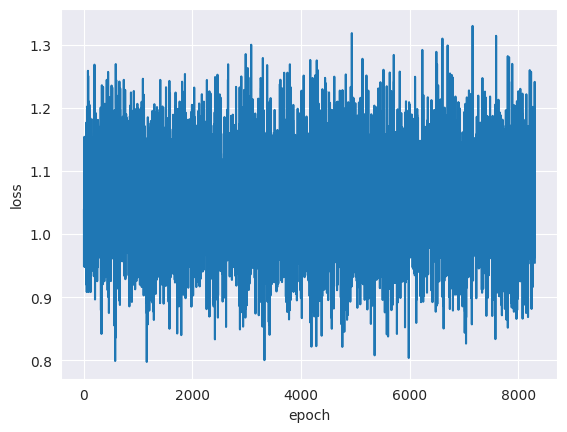

Epoch 1/10, Loss: 8760.8702
Epoch [1/10], Step [100], Loss: 1.1223


KeyboardInterrupt: 

In [166]:
losses = []
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch_idx, loader in enumerate(train_loader):
        texts, labels = loader
        optimizer.zero_grad()
        outputs = model(texts.int().to('cuda'))
        loss = criterion(outputs, labels.to('cuda'))
        losses.append(loss.item()) 
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if (batch_idx + 1) % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{batch_idx + 1}], Loss: {loss.item():.4f}")
    plot_losses(losses)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

In [168]:
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model(texts.int().to('cuda'))
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy().tolist())
        all_labels.extend(labels.cpu().numpy().tolist())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.4801
